In [273]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates 
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import statsmodels.formula.api as smf
import pyfixest as pf

pd.set_option('display.max_columns', 100)
style.use("fivethirtyeight")


# Prepare data

The code below is described in the presentation 
https://docs.google.com/presentation/d/1gO-mXl1RBJlqV3P5a3zqsUiYcnQn3FaBVou7awTAxz8/edit#slide=id.g2ef357d9a9f_0_0

All products/items from Prozorro in 2023-2024 in Prozorro on the 30190000-7 Office equipment market.

In 2023-2024, we had 518,601 price records for the office market. After cleaning missing values, 237,260 positions remained for 89,947 unique tenders/lots. 

In [291]:
df = pd.read_csv('./3019/dirty_prozorro_with_prices_cpv3019.csv',sep=';')
df = df[1:]
print(df.shape)
df = df[df['Поточна ціна за одиницю предмета лота (Валюта)']!='-']
print(df.shape)
df['date'] = pd.to_datetime(df['Дата'],format='%d.%m.%Y')
df['price'] = pd.to_numeric(df['Поточна ціна за одиницю предмета лота (Валюта)'].str.replace(',','.').str.replace(' ',''))
df['price_vat'] = df.apply(lambda x: x['price']*1.2 if x['Чи включено ПДВ у поточну ціну предмета лота']=='0' else x['price'],axis=1)
df = df[df['price']>0]
print(df.shape)
df = df.rename(columns={'Ідентифікатор лота':'lot_id','Назва предмета лота':'product_description_ukr'})
df

(518601, 10)
(260516, 10)
(237260, 13)


,lot_id,Клас CPV предмета лота,product_description_ukr,Початкова ціна за одиницю предмета лота (Валюта),Очікувана кількість одиниць предмета лота,Поточна ціна за одиницю предмета лота (Валюта),Чи включено ПДВ у поточну ціну предмета лота,Класифікація CPV предмета лота,Дата,Count([Ідентифікатор лота]),date,price,price_vat
1,UA-2022-02-23-011883-a-L1,30190000-7 Офісне устаткування та приладдя різне,канцелярські товари,"642,86",7,642.86,0,30197000-6 Дрібне канцелярське приладдя,04.03.2024,1,2024-03-04,642.86,771.432
2,UA-2022-03-10-000349-b-L1,30190000-7 Офісне устаткування та приладдя різне,"папір офісний А4, канцелярські товари (файли, ...",68,100,68,0,30190000-7 Офісне устаткування та приладдя різне,13.01.2023,1,2023-01-13,68.00,81.600
3,UA-2022-03-17-000847-b-L1,30190000-7 Офісне устаткування та приладдя різне,Папір для фотокопіювання та ксерографії,125,8,125,0,30197642-8 Папір для фотокопіювання та ксерогр...,16.02.2023,1,2023-02-16,125.00,150.000
4,UA-2022-04-01-000686-c-L1,30190000-7 Офісне устаткування та приладдя різне,ДК 021-2015:30190000-7 Офісне устаткування та ...,112.7,30,112.7,0,30190000-7 Офісне устаткування та приладдя різне,17.07.2023,1,2023-07-17,112.70,135.240
5,UA-2022-05-05-001087-a-L1,30190000-7 Офісне устаткування та приладдя різне,Скоби до степлера,12,2,12,0,30197110-0 Скоби,27.01.2023,1,2023-01-27,12.00,14.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434757,UA-2024-04-01-010911-a-L1,30190000-7 Офісне устаткування та приладдя різне,Папір офісний MMnexo Everyday А4х500,170,75.0,170,0,30190000-7 Офісне устаткування та приладдя різне,01.04.2024,1,2024-04-01,170.00,204.000
434759,UA-2024-04-01-010924-a-L1,30190000-7 Офісне устаткування та приладдя різне,Папір офісний А4 80гр.,220,85.0,220,0,30197630-1 Папір для друку,01.04.2024,1,2024-04-01,220.00,264.000
434763,UA-2024-04-01-011020-a-L1,30190000-7 Офісне устаткування та приладдя різне,Стилус,"1198,98",1.0,1198.98,0,30190000-7 Офісне устаткування та приладдя різне,01.04.2024,1,2024-04-01,1198.98,1438.776
434764,UA-2024-04-01-011021-a-L1,30190000-7 Офісне устаткування та приладдя різне,"Папір ксероксний А4 80г/м2 ""Maestro extra"" кла...",200,5.0,200,0,30197630-1 Папір для друку,01.04.2024,1,2024-04-01,200.00,240.000


<Axes: xlabel='date', ylabel='# of purchase by months'>

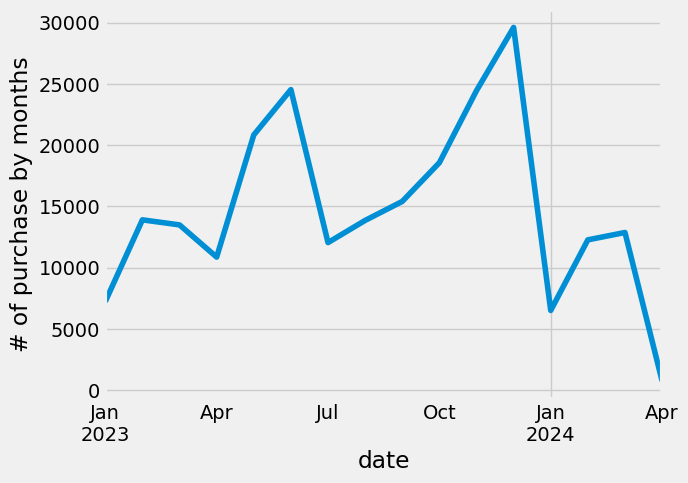

In [287]:
df.groupby([pd.Grouper(key='date',axis=0,freq='M')])['lot_id'].count().plot(ylabel='# of purchase by months')

Also, to speed up clustering, I additionally divide the product descriptions by the last word that matches subgroups in order to cluster them (otherwise the matrix will be too large) and memory problems will arise. As a result, we have 211525 records, which we will divide into different clusters

In [277]:
# print(df.shape)
# df = df[df['Клас CPV предмета лота']=='30190000-7 Офісне устаткування та приладдя різне']
# print(df.shape,df.drop_duplicates(subset='lot_id').shape)

In [292]:
def clean_text_product_description(text): 
    text = re.sub(r'\|','', text)
    text = re.sub(r'х|Х',' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    text = text.lower()
    words = text.split()
    stopwords = ["в",'х','г','л','т','см','мм', "а",'по','арк' ,"на", "до","copy",'м2','м2','та',
                 'для','з','мм','шт','м2','різне','кг','товари','021','2015','ДК']
    no_words = [w for w in words if w not in stopwords and len(w)>1]
    text = " ".join(no_words)     
    # print(text)
    return text


df['title'] = df['product_description_ukr'].apply(clean_text_product_description)
df['numbers1'] = df['title'].apply(lambda x: x.split()[:2])
df['numbers2'] = df['title'].apply(lambda x: re.findall('\d+',x)[:3])
df['numbers'] = np.array(df['numbers1']+df['numbers2'])


In [293]:
def divide_into_subclusters(df): 
    print(df.shape)
    df['first_word'] = df['title'].apply(lambda x: 'none' if len(x.split())==0 else x.split()[0])
    df['count_first_word'] = df.groupby(['first_word'])['first_word'].transform('count')
    df = df[df['count_first_word']>200]
    print(df.shape)
    return df

df = divide_into_subclusters(df)

(237260, 17)
(211525, 19)


In [294]:
def clustering(df):
    # num_words = 5000
    embedding_dim = 64
    max_length = 10
    trunc_type = 'post'
    padding_type = 'post'
    oov_tok = '<OOV>'
    training_portion = .8
    
    tokenizer = Tokenizer(oov_token=oov_tok)
    tokenizer.fit_on_texts(df['numbers'])
    word_index = tokenizer.word_index
    # print(dict(list(word_index.items())[0:10]))
    
    matrix = tokenizer.texts_to_matrix(df['numbers'])
    # print(df['numbers'].iloc[0],matrix.shape)
    
    from sklearn.cluster import KMeans 
    n_clusters = 200
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    df["Cluster_"] = labels
    df["Cluster"] = df.apply(lambda x: x['first_word']+'-'+str(x['Cluster_']),axis=1)
    return df


data = []
for d in df['first_word'].value_counts().index:
    df_ = df[df['first_word']==d]
    print('==>',d,df_.shape)
    df_ = clustering(df_)
    data.append(df_)

df = pd.concat(data)

print(df.shape)

==> папір (41509, 19)
==> папка (14266, 19)
==> ручка (13576, 19)
==> канцелярські (8798, 19)
==> офісне (7777, 19)
==> канцтовари (6204, 19)
==> маркер (5903, 19)
==> клей (5625, 19)
==> скоби (5445, 19)
==> коректор (5061, 19)
==> скотч (4638, 19)
==> олівець (4412, 19)
==> файл (3982, 19)
==> біндер (3372, 19)
==> степлер (3365, 19)
==> скріпки (3354, 19)
==> файли (3278, 19)
==> зошит (2957, 19)
==> конверт (2534, 19)
==> стрічка (2531, 19)
==> швидкозшивач (2412, 19)
==> гумка (2197, 19)
==> дк (2194, 19)
==> штамп (1905, 19)
==> лінійка (1810, 19)
==> ножиці (1762, 19)
==> набір (1729, 19)
==> календар (1682, 19)
==> придбання (1594, 19)
==> книга (1542, 19)
==> блок (1509, 19)
==> ручки (1440, 19)
==> канцелярське (1351, 19)
==> 30190000 (1311, 19)
==> печатка (1266, 19)
==> лоток (1238, 19)
==> фарба (1178, 19)
==> діркопробивач (1175, 19)
==> конверти (1164, 19)
==> ніж (1140, 19)
==> стержень (1077, 19)
==> фотопапір (1019, 19)
==> біндери (1009, 19)
==> олівці (1008, 19)
==>

In [ ]:
def remove_outliers_IQR(data):
    q1=data['price_vat'].quantile(0.25)
    q3=data['price_vat'].quantile(0.75)
    IQR=q3-q1
    data = data[(data['price_vat']>q1-1*IQR)&(data['price_vat']<q3+1*IQR)].reset_index()
    return data

data = []
for cluster in df['Cluster'].unique():
    df_ = df[df['Cluster']==cluster]
    df_ = remove_outliers_IQR(df_)
    data.append(df_)

print(df.shape)
df = pd.concat(data)
print(df.shape)

In [297]:
def remove_small_cluster(df):
    df['count_cluster'] = df.groupby(['Cluster'])['price_vat'].transform('count')
    print(df.shape)
    df = df[df['count_cluster']>50]
    print(df.shape)
    return df

df = remove_small_cluster(df)

print(df.shape)

(172135, 24)
(117554, 24)
(117554, 24)


In [298]:
from scipy import stats
# from sklearn import preprocessing

def calculate_shapiro_and_remove_outlier(df):
    # less then 95%
    df['std'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: x.std())
    df['shapiro'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: stats.shapiro(x).statistic)
    df['price_vat_norm'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: (x - x.mean()) / x.std())
    df['price_vat_log'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: np.log(x))
    print(df.shape)
    df = df[df['shapiro']>=.95]
    print(df.shape)
    return df

df = calculate_shapiro_and_remove_outlier(df)


(117554, 28)
(81171, 28)


After removing outliers and clusters with less than 50 records (it's just an arbitrary number) and records where the Shapiro test is less than 95%, 80,739 records remain

In [255]:
# from scipy.stats import normaltest
# df['normaltest'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: normaltest(x).pvalue)

In [299]:
df = df[['lot_id','product_description_ukr','price_vat','price_vat_norm','price_vat_log',
                       'Cluster','count_cluster','shapiro']]

print(df.shape)

df[:3]

(81171, 8)


,lot_id,product_description_ukr,price_vat,price_vat_norm,price_vat_log,Cluster,count_cluster,shapiro
0,UA-2023-01-02-000692-a-L1,Папір офісний Ф4,268.8,1.475752,5.593968,папір-10,2073,0.988201
1,UA-2023-01-03-003424-a-L1,Папір офісний формату А4,221.7,0.270646,5.401325,папір-10,2073,0.988201
2,UA-2023-01-04-001149-a-L1,Папір офісний А4,292.8,2.089819,5.679490,папір-10,2073,0.988201


In [301]:
df.groupby(['Cluster'])[['shapiro']].agg(['count','mean'])\
.sort_values(by=('shapiro','mean'),ascending=False)[:20]

shapiro          
             count      mean
Cluster                     
папір-113      287  0.990619
папір-10      2073  0.988201
файли-3        127  0.988061
папір-119      102  0.987931
плівка-1       117  0.987367
папір-13      1560  0.987221
клей-0         571  0.986715
папір-2       4058  0.986667
лоток-0        146  0.986561
файл-11        297  0.986376
папір-180      202  0.986169
папір-9        611  0.986151
папір-0       2129  0.985756
папір-1       3874  0.985732
папір-61       103  0.985500
маркер-9       257  0.985498
папір-41       153  0.985427
календар-0     145  0.985397
біндер-14       99  0.985274
клей-28        118  0.985128

Text(0, 0.5, 'Count samples')

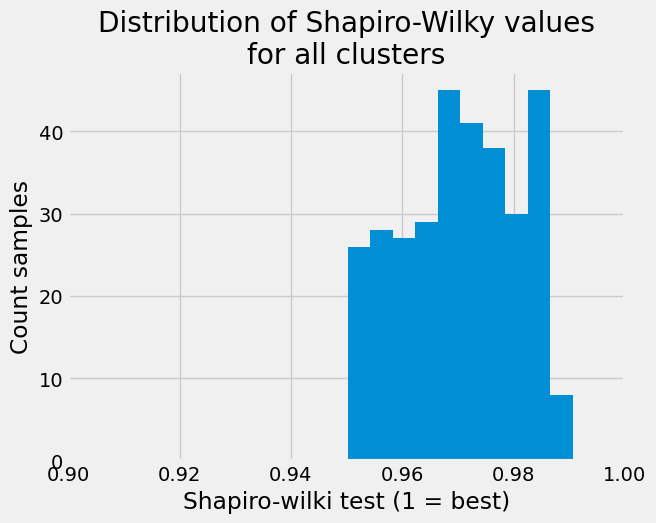

In [302]:
ax = df.groupby(['Cluster'])['shapiro'].agg('mean')\
.plot(kind='hist',bins=10, title='Distribution of Shapiro-Wilky values\nfor all clusters',xlim=[.9,1])
ax.set_xlabel("Shapiro-wilki test (1 = best)")
ax.set_ylabel("Count samples")

<Axes: >

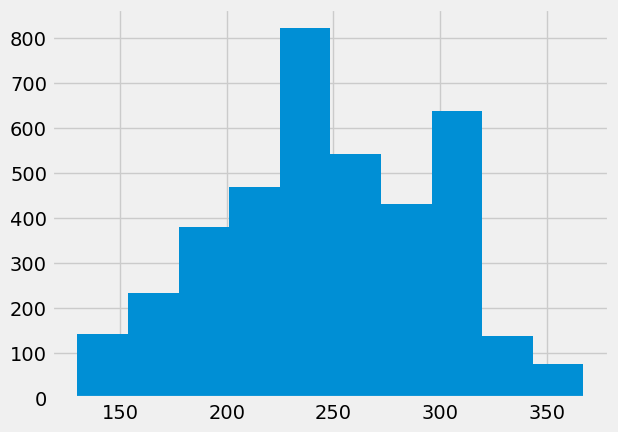

In [303]:
df[df['Cluster']=='папір-1']\
['price_vat'].hist()

Cluster папір-113, count:  287  Shapiro-wilki: 0.9906185257639011
Папір кольоровий А4 80 500а паст. ______Price: 296.0
Папір PREMIUM ECO А4 80гр 500 арк ______Price: 165.0
Папір оф. IQ Premium А4 80 г/м2 (500л) Клас А ______Price: 213.3
Папір офсет 80г/м2 А4 500арк."New Future Laser" ______Price: 216.0
Папір IK ECO COPY A4 80гр 500 арк ______Price: 168.0
----------------------------------------------------------------------------------------------------


Cluster папір-10, count:  2073  Shapiro-wilki: 0.9882008879728589
Папір офісний формату А4 ______Price: 193.2
Папір офісний А4 ______Price: 236.39999999999998
папір офісний  А4 ______Price: 264.0
Папір офісний А4 ______Price: 148.02
Папір офісний А4 для проведення обласних фізкультурно- оздоровчих та спортивних заходів, що включені до Єдиного календарного плану фізкультурно-оздоровчих та спортивних заходів Закарпатської області на 2023 рік з олімпійських видів спорту. ______Price: 186.0
------------------------------------------------

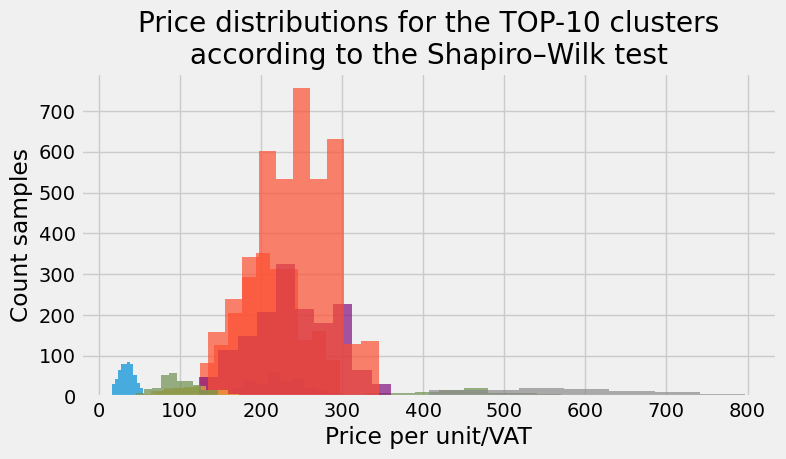

In [304]:
cluster = df.groupby(['Cluster'])['shapiro'].agg(['count','mean'])\
.sort_values(by=('mean'),ascending=False)[:10].index

transactions_per_cluster = 5

fig, ax = plt.subplots(figsize=(8, 4))

for i in cluster:
    transactions = df[df['Cluster'] == i]\
        .sample(transactions_per_cluster, random_state=42)\
    
    print(f"Cluster {i}, count: ",df[df['Cluster'] == i].shape[0],' Shapiro-wilki:', df[df['Cluster'] == i].iloc[0]['shapiro'])
    
    ax = df[df['Cluster'] == i]['price_vat'].plot(kind='hist',alpha=0.7,title='Price distributions for the TOP-10 clusters\naccording to the Shapiro–Wilk test')
    ax.set_xlabel("Price per unit/VAT")
    ax.set_ylabel("Count samples")
    # ax.title("Histogram of Ages")
    
    for index,d in transactions.iterrows():
        print(d['product_description_ukr'],'______Price:',d['price_vat'])

    print("-" * 100)
    print("\n")

In [ ]:
df.to_csv('./0913/prozorro_scu_data_cpv3019.csv',index=False)